# Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2

import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
main_path = "/content/drive/My Drive/chest_xray1/"

In [4]:
train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

In [5]:
pneumonia_train_images = glob.glob(train_path+"/PNEUMONIA/*.jpeg")
normal_train_images = glob.glob(train_path+"/NORMAL/*.jpeg")

In [6]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train_images) , [1] *  len(pneumonia_train_images)]),columns=["class"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


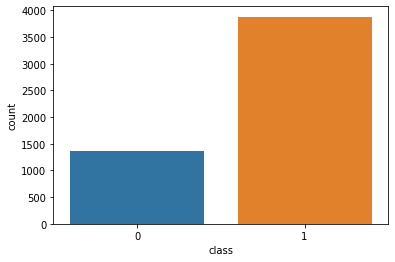

In [7]:
sns.countplot(data['class'],data=data)

### Clear imbalance between normal and pneumonia class

# Defining Image Generators
1. Using **ImageDataGenerator** , to augment our images so as to create a larger dataset for our model to train on.
2. Also to deal with the imbalanced number of data points of the given classes

In [8]:
# define the type of augmentation techniques we will apply.
train_Datagen = ImageDataGenerator(
    rescale =1/255,
    #shear_range=10,
    zoom_range = 0.2,
    #horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
#     rotation_range=20,
    fill_mode = 'nearest',
)
val_datagen = ImageDataGenerator(
    rescale = 1/255
)

# Defining model
* Using pre-trained VGG-16 model.
* Freezing all the layers of model to train.
* Using RMSProp as optimiser
* Also  using learning rate decay to optimize the learning process.

In [9]:
conv_base = VGG16(include_top = False,weights='imagenet')
for i in conv_base.layers:
    i.trainable=False
X = conv_base.output
X = keras.layers.GlobalAveragePooling2D()(X)
X = keras.layers.Dense(128,activation='relu')(X)
predictions = keras.layers.Dense(1,activation='sigmoid')(X)
model= keras.Model(conv_base.input,predictions)
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.RMSprop(lr_schedule),
             metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Creating augmented data from the above defined image data generators

In [11]:
train_generator=train_Datagen.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size= 32,
    class_mode='binary'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(150,150),
        batch_size=8,
        class_mode='binary'
)
test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

Found 5252 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch = 163,
    epochs=20,
    validation_data = validation_generator
)

Epoch 1/20
163/163 [==============================] - 93s 533ms/step - loss: 0.9296 - accuracy: 0.8082 - val_loss: 0.3973 - val_accuracy: 0.8125
Epoch 2/20
163/163 [==============================] - 84s 514ms/step - loss: 0.3301 - accuracy: 0.8730 - val_loss: 0.5329 - val_accuracy: 0.8125
Epoch 3/20
163/163 [==============================] - 82s 501ms/step - loss: 0.2732 - accuracy: 0.8994 - val_loss: 0.3861 - val_accuracy: 0.8125
Epoch 4/20
163/163 [==============================] - 84s 515ms/step - loss: 0.2524 - accuracy: 0.9059 - val_loss: 0.1783 - val_accuracy: 1.0000
Epoch 5/20
163/163 [==============================] - 82s 505ms/step - loss: 0.2395 - accuracy: 0.9086 - val_loss: 0.4605 - val_accuracy: 0.8125
Epoch 6/20
163/163 [==============================] - 82s 501ms/step - loss: 0.2276 - accuracy: 0.9152 - val_loss: 0.4815 - val_accuracy: 0.8125
Epoch 7/20
163/163 [==============================] - 84s 515ms/step - loss: 0.2250 - accuracy: 0.9150 - val_loss: 0.1383 - val_ac

In [13]:
accuracy=model.evaluate_generator(test_generator,624)[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [14]:
accuracy

0.9006410241127014

# Unfreezing the layers of model


In [22]:
#unfreeze to fine-tune the model and increase the accuracy
for i in conv_base.layers:
    i.trainable = True


# Finetuning the model
Again training the model with slower learning rate

In [16]:
initial_learning_rate = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_schedule),  # Very slow learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [17]:
model.fit(
    train_generator,
    steps_per_epoch = 163,
    epochs=100,
    validation_data = validation_generator
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


163/163 [==============================] - 93s 547ms/step - loss: 0.2429 - binary_accuracy: 0.9187 - val_loss: 0.1838 - val_binary_accuracy: 0.9375
Epoch 2/100
163/163 [==============================] - 91s 556ms/step - loss: 0.1623 - binary_accuracy: 0.9420 - val_loss: 0.3240 - val_binary_accuracy: 0.8750
Epoch 3/100
163/163 [==============================] - 89s 548ms/step - loss: 0.1432 - binary_accuracy: 0.9510 - val_loss: 0.2965 - val_binary_accuracy: 0.8750
Epoch 4/100
163/163 [==============================] - 91s 557ms/step - loss: 0.1228 - binary_accuracy: 0.9611 - val_loss: 0.2628 - val_binary_accuracy: 0.9375
Epoch 5/100
163/163 [==============================] - 91s 558ms/step - loss: 0.1170 - binary_accuracy: 0.9605 - val_loss: 0.3657 - val_binary_accuracy: 0.8125
Epoch 6/100
163/163 [==============================] - 90s 549ms/step - loss: 0.1065 - binary_accuracy: 0.9659 - val_loss: 0.1866 - val_binary_accuracy: 0.9375
Epoch 7/100
163/163 [==============================]

In [18]:
final_accuracy = model.evaluate_generator(test_generator,624)[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [19]:
final_accuracy

0.9455128312110901

# Model Metrics

In [20]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing the train and validation accuracy and loss

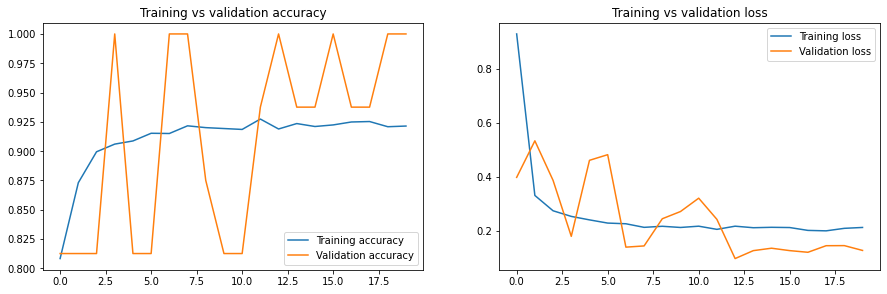

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")

plt.legend()
plt.title("Training vs validation loss")

plt.show()

# Saving the model